In [1]:
import os
PATH = '/content/drive/My Drive/Colab Notebooks/semicond/'

In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/semicond/data/test.zip' -d 'content/'
!unzip '/content/drive/My Drive/Colab Notebooks/semicond/data/good.zip' -d 'content/'
!unzip '/content/drive/My Drive/Colab Notebooks/semicond/data/defect.zip' -d 'content/'

In [3]:
!cp '/content/drive/My Drive/Colab Notebooks/semicond/model.py' -d './'

In [4]:
test_list = os.listdir('content/test')
#test_list

Data Processing

In [5]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
import time
from tqdm import tqdm
from PIL import Image
from scipy import misc
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from model import ResNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
good_path = 'content/good/'
defect_path = 'content/defect/'
test_path = 'content/test/'
defect_list = os.listdir(defect_path)
good_list = os.listdir(good_path)
test_list = os.listdir(test_path)
print(len(defect_list))
print(len(good_list))
print(len(test_list))

7039
27420
3830


In [6]:
DEFECT_AREA = pd.read_csv(PATH + 'defect_area.csv')

In [7]:
def get_defect_area(file):
    """

    :param file: e.g. 'SOT23DUMMY01_04-APG_ITIS_H52_1_111_4.bmp'
    :return:
    """
    f = file[:-4]
    if len(DEFECT_AREA[DEFECT_AREA['id'] == f]) > 0:
        return DEFECT_AREA[DEFECT_AREA['id'] == f]['x_1'].item(), \
               DEFECT_AREA[DEFECT_AREA['id'] == f]['y_1'].item(), \
               DEFECT_AREA[DEFECT_AREA['id'] == f]['x_2'].item(), \
               DEFECT_AREA[DEFECT_AREA['id'] == f]['y_2'].item()
    return


def imgshow(array, defect_area=None):
    """
    :param array:
    :param defect_area: e.g. = (87, 137, 118, 174)
    :return:
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(np.squeeze(array), cmap='gray')
    if defect_area:
        x1, y1, x2, y2 = defect_area
        anchor = (x1, y1)
        h = y2 - y1
        w = x2 - x1
        ax.add_patch(plt.Rectangle(anchor, w, h, edgecolor='red', facecolor='none'))
        ax.set_title('defect')

    fig.show()
def imgs2torch(imgs: list, path: str):
    """
    :param imgs: list of file name
    :return:
    """
    tensor = np.zeros((len(imgs), 1, 267, 275))
    for i, f in enumerate(imgs):
        tensor[i] = np.array(Image.open(path + f).resize(size=(275, 267)))[np.newaxis, :, :]
    return torch.FloatTensor(tensor)/255

def boostrap_training_data(sample_size, shuffle=True):
    defect_sample = imgs2torch(random.choices(defect_list, k=sample_size), path=defect_path)
    good_sample = imgs2torch(random.choices(good_list, k=sample_size), path=good_path)
    train_x = torch.cat([defect_sample, good_sample], dim=0)
    train_y = torch.cat([torch.ones(sample_size), torch.zeros(sample_size)])
    indices = list(range(sample_size * 2))
    if shuffle:
        random.shuffle(indices)
    return (train_x[indices]), train_y[indices]

In [8]:
# x, y = boostrap_training_data(100, shuffle=False)
# print(x.shape)
# print(y.shape)

Example defect semiconductor 

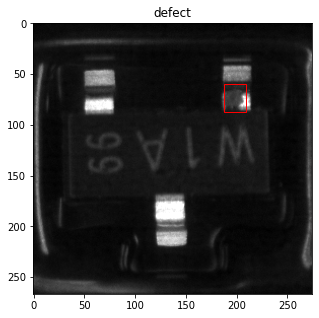

In [9]:
f = random.choice(defect_list)
img = np.array(Image.open(defect_path + f))[np.newaxis, :, :]
defect_area = get_defect_area(f)
imgshow(img, defect_area)

Modeling and training

In [10]:
recorder = {'training_loss': [],
            'train_accuracy': [],
            }

In [11]:
def train(model, device, optimizer, data_x, data_y, epoch):
    model.train()
    avg_loss = 0
    correct = 0
    x_split, y_split = torch.split(data_x, Batch_size),torch.split(data_y, Batch_size)
    count = 0
    for batch_idx, (data, target) in enumerate(zip(x_split, y_split)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, target.unsqueeze(1))
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()


        pred = (output>0.5).float() 
        correct += pred.eq(target.view_as(pred)).sum().item()
        avg_loss += len(data)*loss.item()

        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, count, len(data_x), 100. *count/len(data_x), loss.item()))
        count += len(data)
    avg_loss /= len(data_x)
    recorder['training_loss'].append(avg_loss)
    recorder['train_accuracy'].append(correct/len(data_x))
    print('Epoch: {} Train Accuracy: {}/{} ({:.2f}%)\n  Train Loss: {:.6f}'.format(epoch, correct, len(data_y), 100. * correct / len(data_y), avg_loss))

In [12]:
DefectDetector = ResNet(1, 1).to(device)
optimizer = torch.optim.Adam(DefectDetector.parameters(), lr=1e-3)
N_epoch = 100
Batch_size = 100
sample_size = 5000
DefectDetector.num_paras()

3118497

In [13]:
epoch = 0

lr = 0.005
start_time = time.time()
for epoch in range(1, N_epoch + 1):
    if epoch % 20 == 0:
      optimizer = torch.optim.Adam(DefectDetector.parameters(), lr=lr)
      lr *= 0.5
    data_x, data_y = boostrap_training_data(sample_size)
    train(DefectDetector, device, optimizer, data_x, data_y, epoch)
    print(f'{(time.time() - start_time):.3f}s')
    print(f'Remaining: {(time.time() - start_time)/epoch*(N_epoch-epoch):.3f}s')


Train Epoch: 1 [0/10000 (0%)]	Loss: 0.694103
Train Epoch: 1 [500/10000 (5%)]	Loss: 0.748889
Train Epoch: 1 [1000/10000 (10%)]	Loss: 0.657682
Train Epoch: 1 [1500/10000 (15%)]	Loss: 0.666782
Train Epoch: 1 [2000/10000 (20%)]	Loss: 0.605901
Train Epoch: 1 [2500/10000 (25%)]	Loss: 0.492895
Train Epoch: 1 [3000/10000 (30%)]	Loss: 0.468398
Train Epoch: 1 [3500/10000 (35%)]	Loss: 0.410863
Train Epoch: 1 [4000/10000 (40%)]	Loss: 0.469738
Train Epoch: 1 [4500/10000 (45%)]	Loss: 0.358719
Train Epoch: 1 [5000/10000 (50%)]	Loss: 0.473990
Train Epoch: 1 [5500/10000 (55%)]	Loss: 0.332797
Train Epoch: 1 [6000/10000 (60%)]	Loss: 0.424312
Train Epoch: 1 [6500/10000 (65%)]	Loss: 0.388525
Train Epoch: 1 [7000/10000 (70%)]	Loss: 0.347802
Train Epoch: 1 [7500/10000 (75%)]	Loss: 0.385921
Train Epoch: 1 [8000/10000 (80%)]	Loss: 0.339137
Train Epoch: 1 [8500/10000 (85%)]	Loss: 0.412940
Train Epoch: 1 [9000/10000 (90%)]	Loss: 0.317094
Train Epoch: 1 [9500/10000 (95%)]	Loss: 0.284721
Epoch: 1 Train Accuracy: 7

In [14]:
torch.save(DefectDetector.state_dict(), 'DefectDetector_stra_conv')

In [15]:
import pickle
with open('record.pickle', 'wb') as rec:
    pickle.dump(recorder, rec, protocol=pickle.HIGHEST_PROTOCOL)

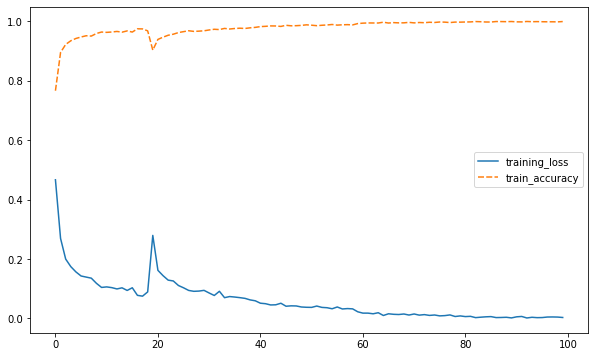

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

record = pd.DataFrame(recorder)
fig, axe = plt.subplots(figsize=(10, 6))
sns.lineplot(data=record[['training_loss', 'train_accuracy']], ax=axe)
# axe.set_title('Sampling without replacement')
fig.show()

In [ ]:
DefectDetector.load_state_dict(torch.load('DefectDetector', map_location='cpu'))

In [20]:
DefectDetector.eval()
prediction = pd.read_csv(PATH + 'submission_sample.csv')
prediction
for i in (prediction.index):
    x = imgs2torch([prediction.loc[i, 'id'] + '.bmp'], path=test_path).to(device)
    prediction.loc[i, 'defect_score'] = DefectDetector(x).detach().item()

In [21]:
prediction.to_csv('prediction.csv', index=False)

In [22]:
prediction

,id,defect_score
0,WEP937068H1A_21-5CW-ITISA46-1_254_2,9.160757e-13
1,WEP93700163A_51-APG_ITIS_H13_2_179_1,9.999999e-01
2,WEP937078H4A_38-5CW-ITISA44-1_42_2,1.616998e-08
3,WEA938001H3A_41-5CW-ITISA51-1_40_2,2.254479e-06
4,WEL92208756A_02-U3W-ITISA09-2_165_3,3.026562e-05
...,...,...
3825,WEP93622711A_47-LJW-ITISA56-2_198_1,1.539288e-08
3826,WEL938428H5A_05-APG_ITIS_H13_2_321_3,1.239596e-02
3827,WEP93724811A_26-5CW-ITISA43-1_103_4,5.927472e-06
3828,WEL93407711A_03-JVW-ITISA13-1_344_1,1.413326e-05


Feature extraction and visualization

In [ ]:
DefectDetector = ResNet(1, 1).to(device)
DefectDetector.load_state_dict(torch.load('DefectDetector'))
DefectDetector.eval()
tensor, label = boostrap_training_data(100, shuffle=False)
tensor, label = tensor.to(device), label.to(device)
# 1000 defect vs 1000 good
extracted_feaure = DefectDetector.activation_vector(tensor)

In [ ]:
torch.save(tensor, 'original_ts')
torch.save(extracted_feaure, 'feature')
torch.save(label, 'label')

In [ ]:
import numpy as np
from abc import ABC
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim


class DynaConv(nn.Module, ABC):
    def __init__(self, in_planes, out_planes):
        super(DynaConv, self).__init__()
        # self.bn = nn.BatchNorm2d(in_planes)
        self.conv_1 = \
            nn.Conv2d(in_planes, out_planes, kernel_size=(1, 1), stride=1, padding=(0, 0), bias=False)
        self.conv_3 = \
            nn.Conv2d(in_planes, out_planes, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        self.conv_9 = \
            nn.Conv2d(in_planes, out_planes, kernel_size=(9, 9), stride=1, padding=(4, 4), bias=False)
        self.conv_27 = \
            nn.Conv2d(in_planes, out_planes, kernel_size=(27, 27), stride=1, padding=(13, 13), bias=False)
        self.conv_81 = \
            nn.Conv2d(in_planes, out_planes, kernel_size=(81, 81), stride=1, padding=(40, 40), bias=False)
        self.conv_merge = nn.Sequential(
            nn.BatchNorm2d(out_planes * 5),
            nn.Conv2d(5 * out_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False),
            # nn.BatchNorm2d(out_planes),
            # nn.ReLU()
        )

    def forward(self, x):
        x1 = self.conv_1(x)
        x2 = self.conv_3(x)
        x3 = self.conv_9(x)
        x4 = self.conv_27(x)
        x5 = self.conv_81(x)
        x = self.conv_merge(torch.cat([x1, x2, x3, x4, x5], dim=1))
        return x